In [1]:
from pycuGMRES import *

importing pycuGMRES
nvcc -lcublas -lcufft -lcusolver -O3 --compiler-options -fPIC -shared "CUDA C ++ sources" -o cuGMRES.so
pycuGMRES library is ready to use!



In [4]:
# //extern "C" {
# void *pycumalloc(unsigned int amount, size_t unit_size, cudaError_t *err)
# {
#     void *dev_array;
#     unsigned int size = amount * unit_size;

#     *err = cudaMalloc(&dev_array, size);

#     return dev_array;
# }
# //}

# pycumalloc = get_function('pycumalloc', path_to_so)
# pycumalloc.argtypes = [c_uint, c_size_t, POINTER(c_uint)]
# pycumalloc.restype = c_void_p

# cudaError_t * - POINTER(c_uint)

SyntaxError: invalid syntax (<ipython-input-4-c58a0e2c2942>, line 1)

In [2]:
# void pycuInitSolution(
#     cuComplex *dev_solution,
#     const float h_sigma,
#     const unsigned int N,
#     const float wavenumber,
#     const float eps_ex
#              )

# pycuInitSolution.argtypes = [
#     POINTER(c_complex), # cuComplex          *dev_solution
#     c_float,            # const float         h_sigma
#     c_uint,             # const unsigned int  N
#     c_float,            # const float         wavenumber
#     c_float             # const float         epsilon_external
#     ]

SyntaxError: invalid syntax (<ipython-input-2-891179eb665d>, line 1)

In [7]:
def set_params(N, Nsqrd, maxiter = 30, tolerance = 0.00001, wavelength_per_domain = 6):
    wavenumber = 2 * np.pi / ( N / wavelength_per_domain )
    cylinder_mask = get_cylinder_mask(N)                                   # bool *dev_mask

    h_mask = (c_bool * Nsqrd)()
    
    h_cuda_err = (c_uint * 1)(0)
    
#     visualize(np.abs(cylinder_mask).reshape(N, N), show_cbar=False)
    py_to_ctype(cylinder_mask.reshape(N, N), h_mask)
    dev_mask = pycumalloc(Nsqrd, c_size_t(sizeof(c_bool)), h_cuda_err)
    pycuhost2gpu(h_mask, dev_mask, Nsqrd, c_size_t(sizeof(c_bool)))
    dev_mask = cast(dev_mask, POINTER(c_bool))

    dev_solution = pycumalloc(Nsqrd, c_size_t(sizeof(c_complex)), h_cuda_err)          # cuComplex *dev_solution
    dev_solution = cast(dev_solution, POINTER(c_complex))
    h_for_gradient = c_bool(False)                                         # const bool for_gradient
    h_index_of_max = c_uint(0)                                             # const unsigned int h_index_of_max
    h_tolerance = c_float(tolerance)                                       # const float tolerance
    h_GMRES_n = (c_uint * 1)(0)                                            # unsigned int *GMRES_n
    dev_actual_residual = pycumalloc(maxiter+1, c_size_t(sizeof(c_float)), h_cuda_err) # float *dev_actual_residual
    dev_actual_residual = cast(dev_actual_residual, POINTER(c_float))
    h_res_vs_tol_p = c_bool(True)                                          # bool *h_res_vs_tol_p
    h_N = c_uint(N)                                                        # const unsigned int N    
    
#     h_sigma = c_float(400/1024 * N)
    h_sigma = c_float(-1)
    h_wavenumber = c_float(2 * 3.14 / ( N / wavelength_per_domain)) # 6 wavelengths per domain
    h_epsilon_internal = c_float(2.25)
    h_epsilon_external = c_float(1.)
    
    pycuInitSolution(dev_solution, h_sigma, h_N, h_wavenumber, h_epsilon_external)

    h_gamma_array = (c_complex * (2 * N - 1) ** 2 )()                      # cuComplex *dev_gamma_array
    gamma_array = get_gamma_array(wavenumber, N).reshape(2 * N - 1, 2 * N - 1).T.reshape(-1)
# #     print(gamma_array.shape)
    py_to_ctype(gamma_array, h_gamma_array)
    memmove(h_gamma_array, gamma_array.ctypes.data, gamma_array.nbytes)
    dev_gamma_array = pycumalloc((2 * N - 1) ** 2, c_size_t(sizeof(c_complex)), h_cuda_err)
    pycuhost2gpu(h_gamma_array, dev_gamma_array, (2 * N - 1) ** 2, c_size_t(sizeof(c_complex)))
    dev_gamma_array = cast(dev_gamma_array, POINTER(c_complex))
    h_plan = pycuGetPlan(h_N)                                              # const cufftHandle plan
    h_handle_p = pycuHandleBlas()                                          # cublasHandle_t handle
    h_cusolverH_p = pycuHandleSolverDn()                                   # cusolverDnHandle_t *cusolverH_p

    h_maxiter = c_uint(maxiter)                                            # unsigned int maxiter

    dev_subs = (c_devSubsidiary * 1)()                                     # dev_subsidiary *dev_subs
    pycuGetSubsidiary(dev_subs, h_N, h_maxiter)
    n_timestamps = get_n_timestamps_val(maxiter)                           # timespec *computation_times
    h_computation_times = (c_timespec * n_timestamps)()    
    
    pycuFFTC2C(dev_gamma_array, dev_gamma_array, h_plan)
    return  dev_mask,\
            dev_solution,\
            h_sigma,\
            h_for_gradient,\
            h_index_of_max,\
            h_tolerance,\
            h_GMRES_n,\
            dev_actual_residual,\
            h_res_vs_tol_p,\
            h_N,\
            dev_gamma_array,\
            h_plan,\
            h_handle_p,\
            h_cusolverH_p,\
            h_maxiter,\
            dev_subs,\
            h_computation_times,\
            h_wavenumber,\
            h_epsilon_internal,\
            h_epsilon_external,\
            h_cuda_err

In [3]:
pycuTestGMRES()

0

In [29]:
maxiter = 30

visible_device = 0
h_visible_device = c_uint(visible_device)
pycuSetDevice(h_visible_device)

for repetition in range(1):
    
    for pow_given in range(10, 11):
        
        N = 1 << pow_given
        Nsqrd = 1 << (pow_given << 1)
        file_an_sol = '/mnt/779188A965FF7E0F/Archive/analytical_solution_' + \
                   str (N) + (False) * '_T'  + '.txt'
    
        N = 1 << pow_given
        dev_mask,\
        dev_solution,\
        h_sigma,\
        h_for_gradient,\
        h_index_of_max,\
        h_tolerance,\
        h_GMRES_n,\
        dev_actual_residual,\
        h_res_vs_tol_p,\
        h_N,\
        dev_gamma_array,\
        h_plan,\
        h_handle_p,\
        h_cusolverH_p,\
        h_maxiter,\
        dev_subs,\
        h_computation_times,\
        h_wavenumber,\
        h_epsilon_internal,\
        h_epsilon_external,\
        h_cuda_err = set_params(N, Nsqrd, maxiter)

        pycuSetPointerMode(h_handle_p, CUBLAS_POINTER_MODE_DEVICE())

        time_c = time()
        
        devh_debug1 = c_void_p()
        devh_debug2 = c_void_p()
        devh_debug3 = c_void_p()

        pycuGMRESold(
            dev_mask,
            dev_solution,
            h_for_gradient,
            h_index_of_max,            
            h_sigma,
            h_maxiter,
            h_tolerance,
            h_GMRES_n,
            dev_actual_residual,
            h_res_vs_tol_p,
            h_N,
            dev_gamma_array,
            h_plan,
            h_handle_p,
            h_cusolverH_p,
            dev_subs,
            h_computation_times,            
            h_wavenumber, #
            h_epsilon_internal, #
            h_epsilon_external,  #          
            devh_debug1,
            devh_debug2,
            devh_debug3
                 )

#         break
        
        time_c = time() - time_c
        
        h_actual_residual = (c_float * (maxiter + 1))()
        pycugpu2host(h_actual_residual, dev_actual_residual, maxiter + 1, c_size_t(sizeof(c_float)))

        print("time_c for GMRES = ", time_c)

        h_analytical_solution = (c_complex * Nsqrd )()    # cuComplex *dev_analytical_solution
        analytical_solution = get_complex_array(file_an_sol)
        py_to_ctype(analytical_solution, h_analytical_solution)
        dev_analytical_solution = pycumalloc(Nsqrd, c_size_t(sizeof(c_complex)), h_cuda_err)
        pycuhost2gpu(h_analytical_solution, dev_analytical_solution, Nsqrd, c_size_t(sizeof(c_complex)))
        dev_analytical_solution = cast(dev_analytical_solution, POINTER(c_complex))
        
        

        pycuSetPointerMode(h_handle_p, CUBLAS_POINTER_MODE_HOST())
        
        h_rel_err =    pycuRelErr(
                                    dev_solution, 
                                    dev_analytical_solution,
                                    h_N,
                                    h_handle_p
                                  )
        
        print("h_rel_err = ", h_rel_err)

        pycuDestroyPlan(h_plan)
        pycuDestroyBlas(h_handle_p)
        pycuDestroySolverDn(h_cusolverH_p)
        pycuFree(dev_gamma_array)
        pycuFree(dev_mask)
        pycuFree(dev_actual_residual)
        pycuDestroySubsidiary(dev_subs)
        pycuFree(dev_analytical_solution)
#         pycuFree(dev_solution)   
        
        
#         pycuDeviceReset()
        
        print('h_actual_residual = ', h_actual_residual[-2])
        
        print("Total time = ", np.sum(get_nano_time(h_computation_times)/1e9))

time_c for GMRES =  1.5816962718963623
h_rel_err =  0.0672600045800209
h_actual_residual =  0.14360566437244415
Total time =  0.0


### For $n = 1024$: 209/415 

In [ ]:


K = len(computation_times)
diff_sec_times = computation_times[1:K]['tv_sec'] - computation_times[0:K - 1]['tv_sec']
diff_nsec_times = computation_times[1:K]['tv_nsec'] - computation_times[0:K - 1]['tv_nsec']
diff_nano_times = 1e9 * diff_sec_times + diff_nsec_times


In [17]:
computation_times = np.asarray(h_computation_times)   
print(type(computation_times['tv_sec']))

<class 'numpy.ndarray'>


In [21]:
K = len(computation_times)

In [24]:
print(np.sum(computation_times[1:K]['tv_nsec'] - computation_times[0:K - 1]['tv_nsec']))

18446744073080933754


In [26]:
18446744073080933754 / 1e9 / 60

307445734.55134887

In [4]:
get_nano_time(h_computation_times)

array([0., 0., 0., ..., 0., 0., 0.])

In [12]:
dev_mask,\
dev_solution,\
h_for_gradient,\
h_index_of_max,\
h_tolerance,\
h_GMRES_n,\
dev_actual_residual,\
h_res_vs_tol_p,\
h_N,\
dev_gamma_array,\
h_plan,\
h_handle_p,\
h_cusolverH_p,\
h_maxiter,\
dev_subs,\
h_computation_times     = set_params(N, Nsqrd, maxiter)

In [8]:
h_solution = (c_complex * Nsqrd)()

In [9]:
pycugpu2host(h_solution, dev_solution, Nsqrd, c_size_t(sizeof(c_complex)))

0

In [10]:
solution = np.zeros((N, N), dtype = np.complex64)

In [11]:
solution = np.ctypeslib.as_array(h_solution)
solution = solution['x'] + 1j * solution['y']

In [12]:
np.max(np.abs(solution))

3.2628684

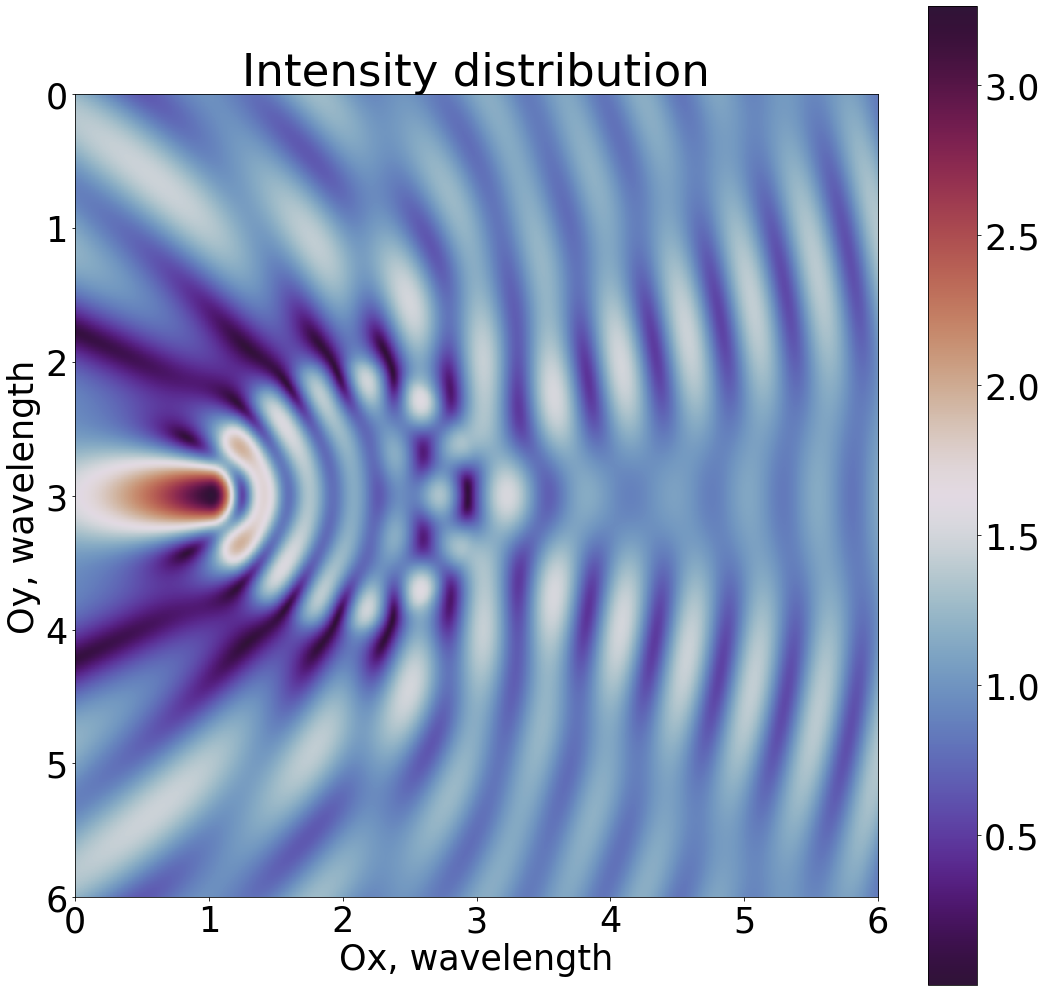

In [24]:
visualize(np.abs(solution).reshape(N, N).T, wavelength_per_domain = 6, title_max = False, title = "Intensity distribution",          
          cmap = 'twilight_shifted') #twilight /twilight_shifted / magma

In [7]:
h_analytical_solution = (c_complex * Nsqrd )()    # cuComplex *dev_analytical_solution
analytical_solution = get_complex_array(file_an_sol)
py_to_ctype(analytical_solution, h_analytical_solution)
dev_analytical_solution = pycumalloc(Nsqrd, c_size_t(sizeof(c_complex)))
pycuhost2gpu(h_analytical_solution, dev_analytical_solution, Nsqrd, c_size_t(sizeof(c_complex)))
dev_analytical_solution = cast(dev_analytical_solution, POINTER(c_complex))

pycuSetPointerMode(h_handle_p, CUBLAS_POINTER_MODE_HOST())
pycuRelErr(
            dev_solution, 
            dev_analytical_solution,
            h_N,
            h_handle_p
          )

0

In [8]:
pycuDestroyPlan(h_plan)
pycuDestroyBlas(h_handle_p)
pycuDestroySolverDn(h_cusolverH_p)
pycuFree(dev_gamma_array)
pycuFree(dev_mask)
pycuFree(dev_actual_residual)
pycuDestroySubsidiary(dev_subs)
pycuFree(dev_analytical_solution)

0

In [9]:
print("Total time = ", np.sum(get_nano_time(h_computation_times)/1e9))

Total time =  0.222711369


In [8]:
# visualize(np.abs(gamma_array).reshape(2 * N - 1,  2 * N - 1), wavelength_per_domain = 6)
    

time_c for GMRES =  0.2388744354248047


In [10]:
h_analytical_solution = (c_complex * Nsqrd )()    # cuComplex *dev_analytical_solution
analytical_solution = get_complex_array(file_an_sol)
py_to_ctype(analytical_solution, h_analytical_solution)
dev_analytical_solution = pycumalloc(Nsqrd, c_size_t(sizeof(c_complex)))
pycuhost2gpu(h_analytical_solution, dev_analytical_solution, Nsqrd, c_size_t(sizeof(c_complex)))
dev_analytical_solution = cast(dev_analytical_solution, POINTER(c_complex))

pycuSetPointerMode(h_handle_p, CUBLAS_POINTER_MODE_HOST())
pycuRelErr(
            dev_solution, 
            dev_analytical_solution,
            h_N,
            h_handle_p
          )

0

In [11]:
pycuDestroyPlan(h_plan)
pycuDestroyBlas(h_handle_p)
pycuDestroySolverDn(h_cusolverH_p)
pycuFree(dev_gamma_array)
pycuFree(dev_mask)
pycuFree(dev_actual_residual)
pycuDestroySubsidiary(dev_subs)
pycuFree(dev_analytical_solution)

0

In [7]:
visible_device = 0
h_visible_device = c_uint(visible_device)
pycuSetDevice(h_visible_device)

0

In [12]:
dev_solution = pycumalloc(Nsqrd, c_size_t(sizeof(c_complex)))          # cuComplex *dev_solution
dev_solution = cast(dev_solution, POINTER(c_complex))
h_N = c_uint(N)   
pycuInitSolution(dev_solution, h_N)
h_solution = (Nsqrd * c_complex)()
pycugpu2host(h_solution, dev_solution, c_uint(Nsqrd), c_size_t(sizeof(c_complex)))
solution = np.ctypeslib.as_array(h_solution)
solution = solution['x'] + 1j * solution['y']

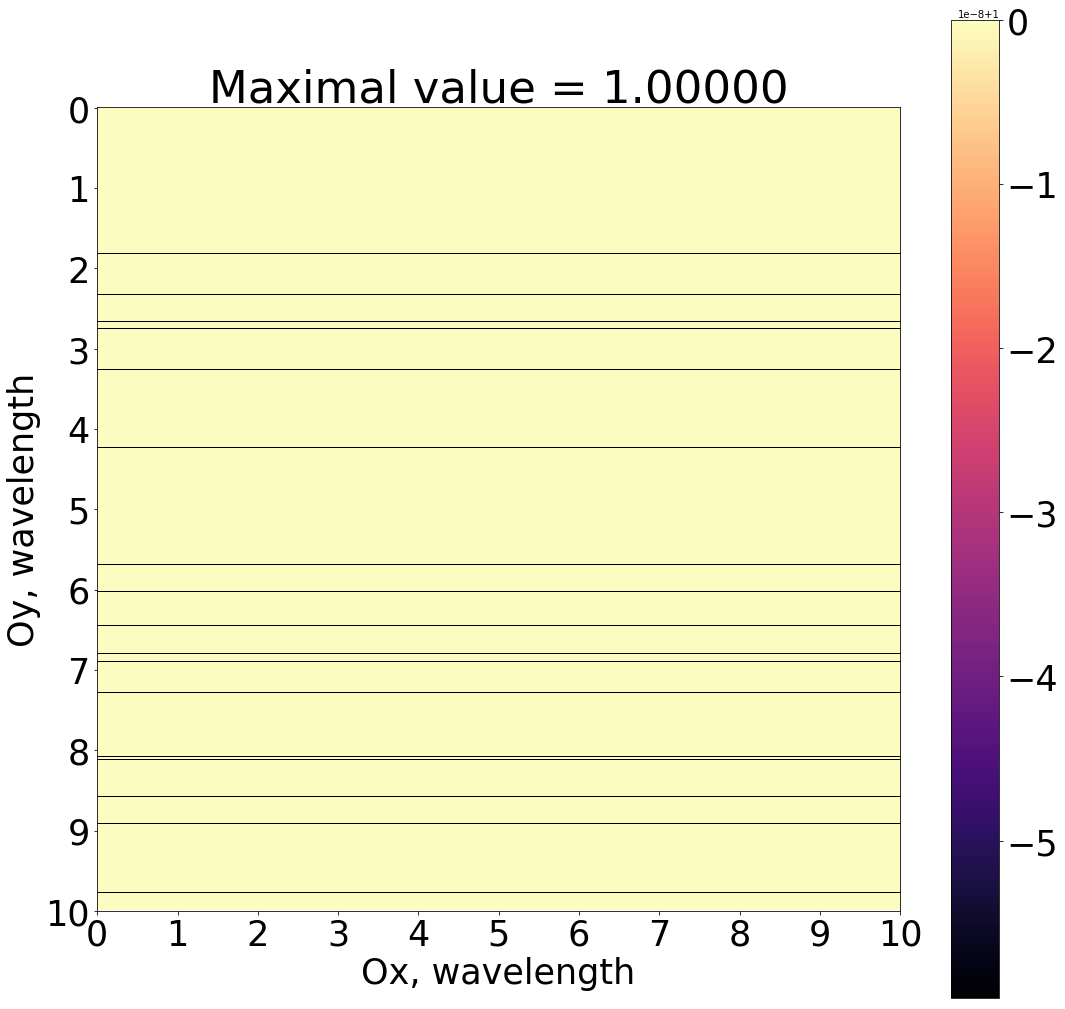

In [13]:
visualize(np.abs(solution).reshape(N, N))

In [6]:
x0 = get_plane_wave(k, size).reshape(size * size)
#np.ones((N, N)) + 1j* np.ones((N, N)) #np.ones((N, N), dtype = np.complex64)
A_x = matvec(x0, eps, k)
r0 = x0.reshape(-1) - A_x.reshape(-1)
normr0 = np.linalg.norm(r0)
v = r0 / normr0

GMRES_i = 0
residual = 1
tol = 1e-12

V = v

if (residual > tol):
    H = np.zeros((2, 1), dtype = np.complex64)
    w = matvec(v, eps, k).reshape(-1)
    H[0, 0] = np.inner(w, v.conj())
    w = w - H[0, 0] * v
    H[1, 0] = np.linalg.norm(w)
    v = w / H[1, 0]
    V = np.hstack((V.reshape(N**2, 1), v.reshape(N**2, 1)))
    Htemp = H
    J = np.zeros((2, 2), dtype = np.complex64)
    
    denominator = np.linalg.norm(Htemp)
    J[1, 1] = J[0, 0] = Htemp[0, 0] / denominator
    J[0, 1] =           Htemp[1, 0] / denominator
    J[1, 0] =         - Htemp[1, 0].conj() / denominator
    Jtotal = J  
    
    
    
#     HH = np.dot(Jtotal, H)
    bb = np.zeros((2, 1), dtype = np.complex64)
    bb[0] = normr0
    c = np.dot(Jtotal, bb)
    residual = abs(c[0, 0])
    print(residual)
    GMRES_i = 1
    
while ((residual > tol) and (GMRES_i < 100)):
    print(GMRES_i)
    H_new = np.zeros((GMRES_i + 2, GMRES_i + 1), dtype = np.complex64)
    H_new[0:GMRES_i + 1, 0:GMRES_i] = H
    H = H_new
    w = matvec(v, eps, k).reshape(-1)

    for j in range(GMRES_i + 1):
        H[j, GMRES_i] = np.inner(w, V[:, j].conj())
        w = w - H[j, GMRES_i] * V[:, j]

    H[GMRES_i + 1, GMRES_i] = np.linalg.norm(w)
    v = w / H[GMRES_i + 1, GMRES_i]
    V = np.hstack((V.reshape(N**2, GMRES_i + 1), v.reshape(N**2, 1)))

    Jtotal = np.hstack((Jtotal, np.zeros(GMRES_i+1).reshape(GMRES_i+1, 1)))
    Jtotal = np.vstack((Jtotal, np.zeros(GMRES_i+2).reshape(1, GMRES_i+2)))
    Jtotal[GMRES_i+1, GMRES_i+1] = 1

    Htemp = np.dot(Jtotal, H)
    J = np.eye(GMRES_i + 2, dtype = np.complex64)

    denominator = np.linalg.norm(np.asarray([Htemp[GMRES_i, GMRES_i], Htemp[GMRES_i + 1, GMRES_i]]))
    J[GMRES_i + 1, GMRES_i + 1] = J[GMRES_i, GMRES_i] = Htemp[GMRES_i    , GMRES_i] / denominator
    J[GMRES_i, GMRES_i + 1] =           Htemp[GMRES_i + 1, GMRES_i] / denominator
    J[GMRES_i + 1, GMRES_i] =         - Htemp[GMRES_i + 1, GMRES_i].conj() / denominator

    Jtotal = np.dot(J, Jtotal)
    bb = np.zeros((GMRES_i + 2, 1), dtype = np.complex64)
    bb[0] = normr0
    c = np.dot(Jtotal, bb)
    residual = abs(c[GMRES_i, 0])
    print(residual)

    GMRES_i += 1

HH = np.dot(Jtotal, H)
HH = HH[0 : GMRES_i, :]
cc = c[0 : GMRES_i, 0:1]
cc_new = np.linalg.solve(HH.reshape(GMRES_i, GMRES_i), cc.reshape(GMRES_i, 1))
V = V[:, 0:GMRES_i]
print(V.shape)
print(cc_new.shape)
x_add = np.dot(V, cc_new)
x = x0 + x_add.reshape(-1)

NameError: name 'get_plane_wave' is not defined

In [12]:
print("Total time = ", np.sum(get_nano_time(h_computation_times)/1e9))

Total time =  18446744073.948322


* 
    * Complex functions: <u> rename </u> and deal with  <u> 2 * float </u> 
    * as_ctype quickly: 
            https://stackoverflow.com/questions/47127575/copy-data-from-numpy-to-ctypes-quickly
            https://stackoverflow.com/questions/3195660/how-to-use-numpy-array-with-ctypes
* <strong>windows</strong>/linux CDLL/DLL,  no objdump  by using extern "C"
    * free function
    * dependant on GPU number
    * MIT license
* module(Digits to python variables)
    * <strong> pip install </strong>
    * malloc(3 vars) - separately
    * clear pycuFree / pyFree / del - observe vars
    * github load
    * var order
* checking CUDA upgrade and code
    * \_36\_ finish is zero-nono-time
    * PyPI example